In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tanyachutani","key":"c55ce1a2caba7c782209c089bba480df"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset
!unzip '/content/stanford-dogs-dataset.zip'

## Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tf.keras.preprocessing.text import Tokenizer
import pandas as pd
import numpy as np
import os
import cv2
import re

ModuleNotFoundError: ignored

In [ ]:
wImage,hImage=512,512
nClasses=1

batch_size= 4
epochs=25

In [ ]:
def create_data(trainImage,trainAnnotation):
  trainImagePath=[]
  trainAnnotationPath=[]
  classes=[]

  for folder in os.listdir(trainImage):
    classes.append(folder.split('-')[1])
    for image in sorted(os.listdir(trainImage+'/'+folder)):
      trainImagePath.append(trainImage+'/'+folder+'/'+image)

  for folder in os.listdir(trainAnnotation):
    for image in sorted(os.listdir(trainAnnotation+'/'+folder)):
      trainAnnotationPath.append(trainAnnotation+'/'+folder+'/'+image)
  class_map = {k: index for index, k in enumerate(sorted(classes))}

  #Taking the first 19 classes 
  a=[]
  for i in trainAnnotationPath[:3363]:
    with open (i,encoding="utf8",errors='ignore') as f:
      reader = f.read()
    predClass = str(re.findall('<name>(.+?)</name>', reader)[0])
    a.append(predClass)

  print("Classes",set(a))
  print("No. of Classes",len(set(a)))

  class_map = {k: (index) for index, k in enumerate(sorted(set(a)))}

  trainAnnotationPath = trainAnnotationPath[:3363]
  trainImagePath = trainImagePath[:3363]
  return trainImagePath,trainAnnotationPath,class_map

In [ ]:
def pre_process_data(img,label):
  with open (label,encoding="utf8",errors='ignore') as f:
    reader = f.read()
  predClass = str(re.findall('<name>(.+?)</name>', reader)[0])
  xmin = int(re.findall('(?<=<xmin>)[0-9]+?(?=</xmin>)',\
                        reader)[0])
  xmax = int(re.findall('(?<=<xmax>)[0-9]+?(?=</xmax>)',\
                        reader)[0])
  ymin = int(re.findall('(?<=<ymin>)[0-9]+?(?=</ymin>)',\
                        reader)[0])
  ymax = int(re.findall('(?<=<ymax>)[0-9]+?(?=</ymax>)',\
                        reader)[0])
  orig_width = int(re.findall('(?<=<width>)[0-9]+?(?=</width>)',\
                            reader)[0])
  orig_height = int(re.findall('(?<=<height>)[0-9]+?(?=</height>)',\
                             reader)[0])
  x = int((xmin+xmax)/2)
  y = int((ymin+ymax)/2)
  w = int(xmax-xmin)
  h = int(ymax-ymin)

  #Resizing Bounding box according to resized image
  x = x*wImage/orig_width
  y = y*hImage/orig_height
  w = w*wImage/orig_width
  h = h*hImage/orig_height

  class_index = class_map[predClass]
  label = np.hstack((x,y,w,h,class_index))

  #Converting xywh to x1y1x2y2
  label = tf.stack([label[...,0]-label[...,2]/2.0,
      label[...,1]-label[...,3]/2.0,
      label[...,0]+label[...,2]/2.0,
      label[...,1]+label[...,3]/2.0,
      label[...,4]]
      ,axis=-1)
  
  img_label[img] = label
  return img_label

trainImage='/content/images/Images'
trainAnnotation='/content/annotations/Annotation'
trainImagePath,trainAnnotationPath,class_map = create_data(trainImage,
                                                           trainAnnotation)

img_label=dict()
for i in range(len(trainImagePath)):
  img_label = pre_process_data(trainImagePath[i],
                             trainAnnotationPath[i])

data = pd.DataFrame(img_label.items(), columns=['img', 'label'])

Classes {'Irish_setter', 'kelpie', 'Mexican_hairless', 'Bernese_mountain_dog', 'standard_poodle', 'dhole', 'vizsla', 'Lakeland_terrier', 'Samoyed', 'Scotch_terrier', 'Airedale', 'bloodhound', 'komondor', 'bull_mastiff', 'Great_Pyrenees', 'chow', 'Maltese_dog', 'kuvasz', 'miniature_pinscher'}
No. of Classes 19


In [ ]:
def imshow(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)

In [ ]:
def show_img(img,label):
  img = cv2.imread(img)
  color = (255,0,0)
  img = cv2.resize(img,(hImage,wImage))
  for i,val in enumerate(label):
    start = tuple((np.array(label[i][:2])).astype('int'))
    end = tuple((np.array(label[i][2:4])).astype('int'))
    cv2.rectangle(img,start,end,color,2)
  imshow(img)

In [ ]:
def convert_format(out,format):
  if format == 'x1y1x2y2':
    return tf.stack([out[...,0]-out[...,2]/2.0,
    out[...,1]-out[...,3]/2.0,
    out[...,0]+out[...,2]/2.0,
    out[...,1]+out[...,3]/2.0]
    ,axis=-1)

  elif format == 'xywh':
    return tf.stack([(out[...,0]+out[...,2])/2.0,
    (out[...,1]+out[...,3])/2.0,
    out[...,2]-out[...,0],
    out[...,3]-out[...,1],
    out[...,4]],axis=-1)  ##sending the class also

In [ ]:
def rescale_label(label):
  return tf.stack([label[:,0]*wImage/originW,
  label[:,1]*hImage/originH,
  label[:,2]*wImage/originW,
  label[:,3]*hImage/originH,
  label[:, 4]], axis=-1) ##sending the class also

In [ ]:
def convert_scale(matrix,scale):
  if scale == 'abs':
    return tf.stack([matrix[:,0]*wImage,
    matrix[:,1]*hImage,
    matrix[:,2]*wImage,
    matrix[:,3]*hImage],axis=-1)

  elif scale == 'rel':
    return tf.stack([matrix[:,0]/wImage,
    matrix[:,1]/hImage,
    matrix[:,2]/wImage,
    matrix[:,3]/hImage],axis=-1)    

In [ ]:
def normalised_ground_truth(matched_boxes,feature_box,return_format):
  matched_boxes = tf.cast(matched_boxes,dtype=tf.float32)
  feature_box = tf.cast(feature_box,dtype=tf.float32)
  if return_format == "encode":
    return tf.stack([(matched_boxes[:,0] - feature_box[:, 0]) / (feature_box[:, 2]),
                   (matched_boxes[:,1] - feature_box[:, 1]) / (feature_box[:, 3]),
        tf.math.log(matched_boxes[:,2] / feature_box[:, 2]),
        tf.math.log(matched_boxes[:,3] / feature_box[:, 3])],
        axis=-1)

  elif return_format == "decode":
    return tf.stack([matched_boxes[:,0] * feature_box[:, 2] + (feature_box[:, 0]),
                    matched_boxes[:,1] * feature_box[:, 3] + (feature_box[:, 1]),
          tf.math.exp(matched_boxes[:,2]) * feature_box[:, 2],
          tf.math.exp(matched_boxes[:,3]) * feature_box[:, 3]],
          axis=-1)

In [ ]:
def create_df_box(feature_layers):
  #s_min+(s_max-s_min)/(m-1)*(k-1)
  s_min = 0.2
  s_max = 0.9
  m = 6
  scale=[]

  for k in range(2,8):
    sk = s_min+(s_max-s_min)/(m-1)*(k-1)
    scale.append(sk)
  scale.insert(0,s_min)
  scale.extend([s_max])

  scale =  [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05]

  feature_boxes=[]
  for feature_layer in feature_layers:
    if (feature_layer == 64 or feature_layer == 6 or feature_layer == 4):
      aspect_ratios=[1,2,1/2]
    else:
      aspect_ratios=[1,2,3,1/2,1/3]
    w_ar=[]
    h_ar=[]
    for i in aspect_ratios:
      if i == 1:
        w=scale[feature_layers.index(feature_layer)]*np.sqrt(i)
        h=scale[feature_layers.index(feature_layer)]/np.sqrt(i)
        w_ar.append(w)
        h_ar.append(h)
        sk_1 = np.sqrt(scale[feature_layers.index(feature_layer)]* 
                     scale[feature_layers.index(feature_layer)+1])
        w = sk_1*np.sqrt(i)
        h = sk_1/np.sqrt(i)      
      else:
        w = scale[feature_layers.index(feature_layer)]*np.sqrt(i)
        h = scale[feature_layers.index(feature_layer)]/np.sqrt(i)
      w_ar.append(w)
      h_ar.append(h)
  
    x_axis = np.linspace(0,feature_layer,feature_layer+1)
    y_axis=np.linspace(0,feature_layer,feature_layer+1)
    xx,yy = np.meshgrid(x_axis,y_axis)
    x = [(i+0.5)/(feature_layer) for i in xx[:-1,:-1]]
    y = [(i+0.5)/(feature_layer) for i in yy[:-1,:-1]]

    if (feature_layer == 64 or feature_layer == 6 or feature_layer == 4):
      ndf_box = 4
    else:
      ndf_box = 6
    ndf_boxes = feature_layer*feature_layer*ndf_box
    nbox_coordinates = 4
    feature_box = np.zeros((ndf_boxes,nbox_coordinates))
    x = np.array(x).reshape(feature_layer*feature_layer)
    x = np.repeat(x,ndf_box)
    y = np.array(y).reshape(feature_layer*feature_layer)
    y = np.repeat(y,ndf_box)

    w_ar = np.tile(w_ar,feature_layer*feature_layer)
    h_ar = np.tile(h_ar,feature_layer*feature_layer)
    feature_box[:,0] = x
    feature_box[:,1] = y
    feature_box[:,2] = w_ar
    feature_box[:,3] = h_ar
    feature_boxes.append(feature_box)
  df_box = np.concatenate(feature_boxes,axis=0)
  return df_box

In [ ]:
def iou(box1,box2):
  box1 = tf.cast(box1,dtype=tf.float32)
  box2 = tf.cast(box2,dtype=tf.float32)
  
  x1 = tf.math.maximum(box1[:,None,0],box2[:,0])
  y1 = tf.math.maximum(box1[:,None,1],box2[:,1])
  x2 = tf.math.minimum(box1[:,None,2],box2[:,2])
  y2 = tf.math.minimum(box1[:,None,3],box2[:,3])
  
  #Intersection area
  intersectionArea = tf.math.maximum(0.0,x2-x1)*tf.math.maximum(0.0,y2-y1)

  #Union area
  box1Area = (box1[:,2]-box1[:,0])*(box1[:,3]-box1[:,1])
  box2Area = (box2[:,2]-box2[:,0])*(box2[:,3]-box2[:,1])
  
  unionArea = tf.math.maximum(1e-10,box1Area[:,None]+box2Area-intersectionArea)
  iou = intersectionArea/unionArea
  return tf.clip_by_value(iou,0.0,1.0)


In [ ]:
def df_match(labels,iou_matrix):
  max_values = tf.reduce_max(iou_matrix,axis=1)
  max_idx = tf.math.argmax(iou_matrix,axis=1)
  matched = tf.cast(tf.math.greater_equal(max_values,0.5),
                  dtype=tf.float32)
  gt_box = tf.gather(labels,max_idx)
  return gt_box,matched

In [ ]:
def pre_process_img(img,feature_box_conv,matched):
  img = cv2.imread(img)
  img = cv2.resize(img, (hImage,wImage), interpolation = cv2.INTER_AREA)
  color = (255,0,0)
  matched_idx = np.where(matched)
  for i in (matched_idx):
    for j in i:
      start = feature_box_conv[j,:2]
      end = feature_box_conv[j,2:4]
      start = tuple((start))
      end = tuple((end))
      cv2.rectangle(img,start,end,color,2)
  plt.title('Matched Boxes')
  imshow(img)  

In [ ]:
def parse_data(data):
  parsed_labels = []
  parsed_image_paths =[]
  for row in data.itertuples():
        parsed_image_paths += [row.img]
        label = [list(map(int, row.label))]
        parsed_labels += [np.float32(label)]
  return parsed_image_paths, parsed_labels 

def generator(images, labels):
    def _g():
        indices = np.arange(0, len(images))
        np.random.shuffle(indices)
        for idx in indices:
            yield tf.constant(images[idx]), tf.constant(labels[idx])
    return _g

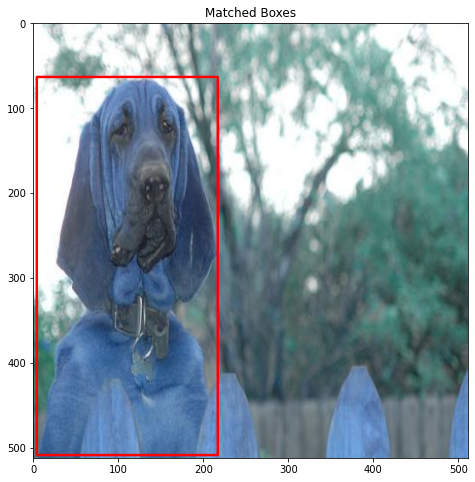

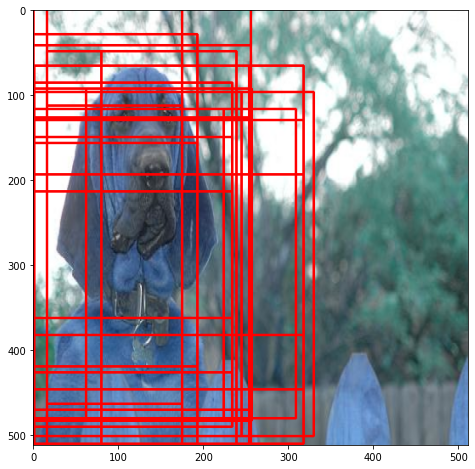

In [ ]:
#Matched Boxes
def create_data(data):
  data = parse_data(data)
  images,labels = data[0],data[1]

  #GT boxes creation
  img = images[62]
  label = labels[62]
  show_img(img,label)
  feature_layers = [64,32,16,8,6,4]
  feature_box = create_df_box(feature_layers)
  feature_box = convert_scale(feature_box,'abs')
  feature_box_conv = convert_format(feature_box,'x1y1x2y2')
  iou_matrix = iou(feature_box_conv,label[:,:4])
  gt_box,matched = df_match(convert_format(label,'xywh'),iou_matrix)
  pre_process_img(img,convert_format(feature_box,'x1y1x2y2'),matched)
  boxes=gt_box[:,:4]
  classes = gt_box[:,4]
  classes = tf.cast(classes+1, dtype=tf.int32) #0 for background class
  matched = tf.cast(matched,dtype=tf.int32)
  classes = tf.cast(classes*matched,dtype=tf.int32)
  classes = tf.one_hot(classes,depth=nClasses+1,dtype=tf.float32)
  normalised_gtbox = normalised_ground_truth(boxes,feature_box,'encode')  
  normalised_gtbox = normalised_ground_truth(normalised_gtbox,feature_box,'decode')
  df_box = tf.concat((normalised_gtbox,classes),axis=-1)
  return df_box
df_box=create_data(data)

In [ ]:
def read_img(img):
  image = tf.io.read_file(img)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.resize(image,[hImage,wImage])
  image = tf.cast(image,tf.float32)
  # normalize image 
  image = (image + tf.constant([103.939, 116.779, 123.68]))[:, :, ::-1]

  return image

In [ ]:
#label
feature_layers = [64,32,16,8,6,4]
feature_box = create_df_box(feature_layers)
feature_box = convert_scale(feature_box,'abs')
feature_box_conv = convert_format(feature_box,'x1y1x2y2')

def main(img,label):
  image = read_img(img)

  iou_matrix = iou(feature_box_conv,label)
  gt_box,matched = df_match(convert_format(label,'xywh'),iou_matrix)
  boxes = gt_box[:,:4]
  classes = gt_box[:,4]

  classes = tf.cast(classes+1, dtype=tf.int32) #0 for background class
  matched = tf.cast(matched,dtype=tf.int32)
  classes = tf.cast(classes*matched,dtype=tf.int32)
  classes = tf.one_hot(classes,depth=nClasses+1,dtype=tf.float32)
  normalised_gtbox = normalised_ground_truth(boxes,feature_box,'encode')
  df_box = tf.concat((normalised_gtbox,classes),axis=-1)
  df_box.set_shape([feature_box.shape[0], 4+nClasses+1])
  return image,df_box


In [ ]:
def data_gen(images, labels):
  autotune = tf.data.experimental.AUTOTUNE
  dataset = tf.data.Dataset.from_generator(generator(images, labels),
                                           (tf.string, tf.float32)) 
  dataset = dataset.map(main, num_parallel_calls=autotune)
  dataset = dataset.batch(batch_size, drop_remainder=True)
  dataset = dataset.repeat(epochs)
  dataset = dataset.prefetch(autotune)
  return dataset


images, labels = parse_data(data)
dataset = data_gen(images, labels)


In [ ]:
#Test Images
test_images = []
test_labels = []
indices = np.arange(0, len(images))
np.random.shuffle(indices)
for i in range(10):
  test_images.append(images[indices[i]])
  test_labels.append(labels[indices[i]])


In [ ]:
def total_loss(y_true,y_pred):
  y_true = tf.cast(y_true,dtype=tf.float32)  
  y_pred = tf.cast(y_pred,dtype=tf.float32)
  pos_mask = tf.cast(tf.equal(tf.squeeze(y_true[:,:,4:5],axis=-1),0.0),tf.float32)
  num_pos = tf.maximum(1.0,tf.cast(tf.math.count_nonzero(pos_mask,axis=-1),tf.float32))
  loc_loss = tf.compat.v1.losses.huber_loss(labels=y_true[:,:,:4],
                                            predictions=y_pred[:,:,:4],
                                            reduction=tf.losses.Reduction.NONE)
                                            
  loc_loss = tf.reduce_sum(loc_loss, axis=-1)
  loc_loss = tf.where(tf.equal(pos_mask, 1.0), loc_loss, 0.0)
  loc_loss = tf.reduce_sum(loc_loss, axis=-1)
  loc_loss = loc_loss/num_pos
  
  cce = tf.losses.CategoricalCrossentropy(from_logits=True,
                                         reduction=tf.losses.Reduction.NONE)
  cross_entropy = cce(y_true[:,:,4:],y_pred[:,:,4:])
  
  #neg:pos 3:1
  num_neg = 3.0*num_pos
  
  #Negative Mining
  neg_cross_entropy = tf.where(tf.equal(pos_mask,0.0),cross_entropy,0.0)
  sorted_dfidx = tf.cast(tf.argsort(neg_cross_entropy,\
                          direction='DESCENDING',axis=-1),tf.int32)
  rank = tf.cast(tf.argsort(sorted_dfidx,axis=-1),tf.int32)
  num_neg = tf.cast(num_neg,dtype=tf.int32)
  neg_loss = tf.where(rank<tf.expand_dims(num_neg,axis=1),neg_cross_entropy,0.0)
  
  pos_loss = tf.where(tf.equal(pos_mask,1.0),cross_entropy,0.0)
  clas_loss = tf.reduce_sum(pos_loss+neg_loss,axis=-1)
  clas_loss = clas_loss/num_pos
  totalloss = loc_loss+clas_loss
  return totalloss


In [ ]:
def conv_layer(filter,kernel_size,
               layer,strides=1,
               padding='same',
               activation='linear',pool=False,
               poolsize=2,poolstride=2,conv=True):
  if conv == True:
      layer = tf.keras.layers.Conv2D(filters=filter,
                                  kernel_size=kernel_size,
                                  strides=strides,
                                  activation=activation,
                                  padding=padding,
                                   kernel_initializer='he_normal')(layer)
      layer = tf.keras.layers.BatchNormalization()(layer)
      layer = tf.keras.layers.ReLU()(layer)
  elif pool == True:
    layer=tf.keras.layers.MaxPool2D(pool_size=(poolsize,poolsize),
                                    strides=poolstride,padding='same')(layer)
  return layer

def ssd_model():
  inputs=tf.keras.layers.Input(shape=(512,512,3))
  outputs=[]
  densenet_121 = tf.keras.applications.DenseNet121(
                                            input_shape=(512,512,3),
                                            include_top = False)
  
  #Feature Layer 1

  layer = densenet_121.get_layer('pool3_relu').output
  output = tf.keras.layers.Conv2D(filters=4*(4+nClasses+1),
            kernel_size=3,
            padding='same',
            kernel_initializer='glorot_normal')(layer)
  output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
  outputs.append(output)
  
  #Feature Layer 2

  layer = densenet_121.get_layer('pool4_relu').output
  output = tf.keras.layers.Conv2D(filters=6*(4+nClasses+1),
            kernel_size=3,
            padding='same',
            kernel_initializer='glorot_normal')(layer)
  output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
  outputs.append(output)


  #Feature Layer 3 
  
  layer = densenet_121.get_layer('relu').output
  output = tf.keras.layers.Conv2D(filters=6*(4+nClasses+1),
          kernel_size=3,
          padding='same',
          kernel_initializer='glorot_normal')(layer)
  output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
  outputs.append(output)

  #Feature Layer 4

  layer = conv_layer(128, 1, layer)
  layer = conv_layer(256, 3, layer, strides=2)
  output = tf.keras.layers.Conv2D(filters=6*(4+nClasses+1),
          kernel_size=3,
          padding='same',
          kernel_initializer='glorot_normal')(layer)
  output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
  outputs.append(output)
  
  #Feature Layer 5 

  layer = conv_layer(128, 1, layer,padding= 'valid')
  layer = conv_layer(256, 3, layer,padding= 'valid')
  output = tf.keras.layers.Conv2D(filters=4*(4+nClasses+1),
          kernel_size=3,
          padding='same',
          kernel_initializer='glorot_normal')(layer)
  output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
  outputs.append(output)
                 
  #Feature Layer 6 

  layer = conv_layer(128, 1, layer,padding= 'valid')
  layer = conv_layer(256, 3, layer,padding= 'valid')
  output = tf.keras.layers.Conv2D(filters=4*(4+nClasses+1),
        kernel_size=3,
        padding='same',
        kernel_initializer='glorot_normal')(layer)
  output = tf.keras.layers.Reshape([-1, 4+nClasses+1])(output)
  outputs.append(output)

  out = tf.keras.layers.Concatenate(axis=1)(outputs)
  model = tf.keras.models.Model(densenet_121.input,out)
  model.summary()
  return model

In [ ]:
optimizer = tf.optimizers.Adam(0.001)

model = ssd_model()

model.compile(optimizer=optimizer,
            loss=total_loss)

callback=tf.keras.callbacks.ModelCheckpoint(
        filepath=
        'content/ssd_model.h5',
        monitor='total_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=1)

step_per_epoch = len(data)//batch_size

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 518, 518, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 256, 256, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
model.fit(dataset,epochs=25,                    
          steps_per_epoch=step_per_epoch)

Epoch 1/25
840/840 [==============================] - 128s 152ms/step - loss: 5.4711
Epoch 2/25
840/840 [==============================] - 128s 152ms/step - loss: 4.7985
Epoch 3/25
840/840 [==============================] - 128s 152ms/step - loss: 4.4840
Epoch 4/25
840/840 [==============================] - 127s 152ms/step - loss: 4.2447
Epoch 5/25
840/840 [==============================] - 127s 151ms/step - loss: 4.0321
Epoch 6/25
840/840 [==============================] - 128s 152ms/step - loss: 3.8476
Epoch 7/25
840/840 [==============================] - 127s 152ms/step - loss: 3.6584
Epoch 8/25
840/840 [==============================] - 127s 152ms/step - loss: 3.4597
Epoch 9/25
840/840 [==============================] - 127s 151ms/step - loss: 3.2980
Epoch 10/25
840/840 [==============================] - 128s 152ms/step - loss: 3.0944
Epoch 11/25
840/840 [==============================] - 128s 152ms/step - loss: 2.9528
Epoch 12/25
840/840 [==============================] - 128s 152

In [ ]:
def decode(y_pred,df_box):
  y_preds = tf.squeeze(y_pred,axis=0)
  df_box = tf.cast(df_box,dtype=tf.float32)
  boxes = y_preds[:,:4]
  boxes = normalised_ground_truth(boxes,df_box,'decode')
  boxes_x1y1 = convert_format(boxes,'x1y1x2y2')
  y_preds = tf.nn.softmax(y_preds[:,4:])
  cls_idx = tf.argmax(y_preds, axis=-1)
  cls_scores = tf.reduce_max(y_preds, axis=-1)
  
  #Filter out the backgrund class
  foreground_idx = tf.where(cls_idx != 0)[:, 0]

  filtered_boxes = tf.gather(boxes_x1y1, foreground_idx)
  filtered_cls_idx = tf.gather(cls_idx, foreground_idx)
  filtered_cls_scores = tf.gather(cls_scores, foreground_idx)
  filtered_cls_idx = filtered_cls_idx-1

  filtered_boxes_y1x1 = tf.stack([filtered_boxes[:,1],
                                filtered_boxes[:,0],
                                filtered_boxes[:,3],
                                filtered_boxes[:,2]],axis=-1)  
  nms_idx = tf.image.non_max_suppression(filtered_boxes_y1x1,
                                          filtered_cls_scores,
                                          max_output_size=20,
                                          iou_threshold=0.5,
                                          score_threshold=1e-2)
  final_boxes = tf.gather(filtered_boxes, nms_idx)
  final_cls_idx = tf.gather(filtered_cls_idx, nms_idx)
  final_cls_scores = tf.gather(filtered_cls_scores, nms_idx)
  return final_boxes, final_cls_idx, final_cls_scores

In [ ]:
def decoder_show_img(img,label,class_idx,class_map):
  img=cv2.imread(img)
  color=(255,0,0)
  font = cv2.FONT_HERSHEY_SIMPLEX 
  fontScale = 0.65
  thickness = 1
  class_map = {value:key for key, value in class_map.items()}
  img=cv2.resize(img,(hImage,wImage))
  img = (img + tf.constant([103.939, 116.779, 123.68]))[:, :, ::-1]
  for i,val in enumerate(label):
    start=tuple((tf.cast((label[i][:2]),dtype=tf.int32).numpy()))
    end=tuple((tf.cast((label[i][2:4]),dtype=tf.int32).numpy()))
    cv2.rectangle(img.numpy(),start,end,color,2)
    cv2.putText(img.numpy(),class_map[int(class_idx)],
                start,font,fontScale,color, thickness, cv2.LINE_AA)    
  imshow(img)

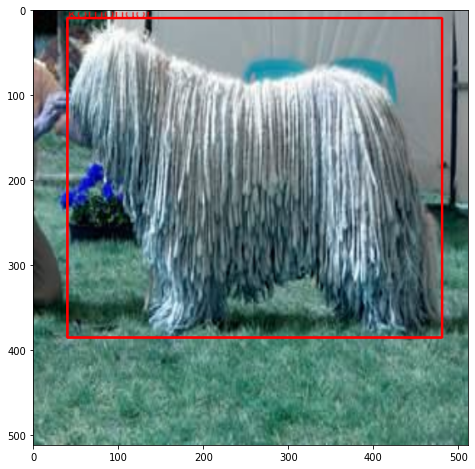

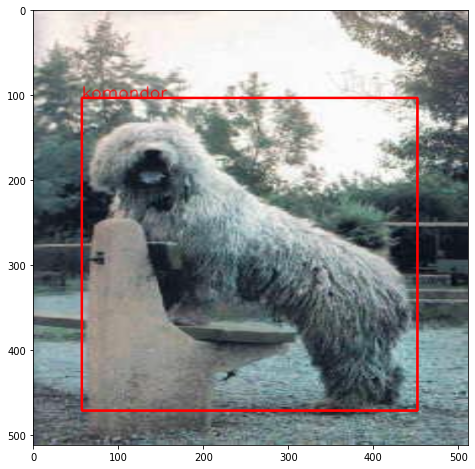

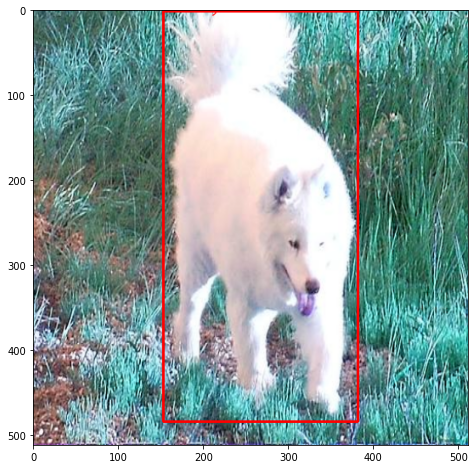

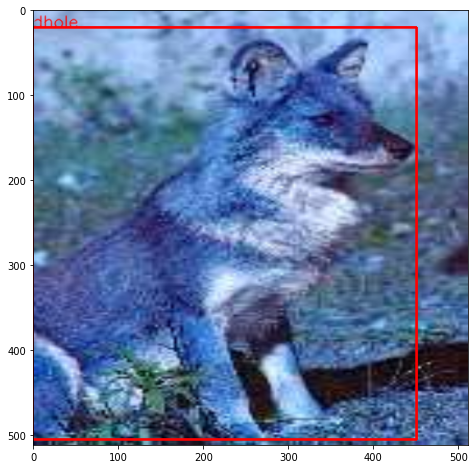

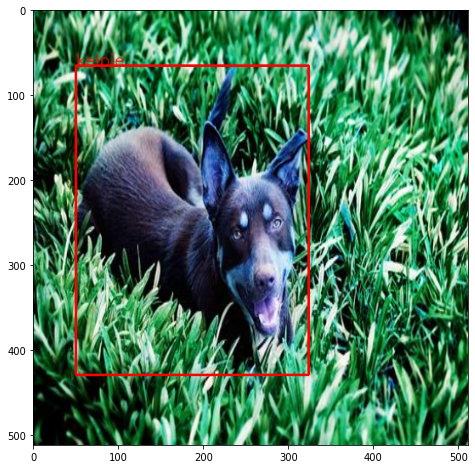

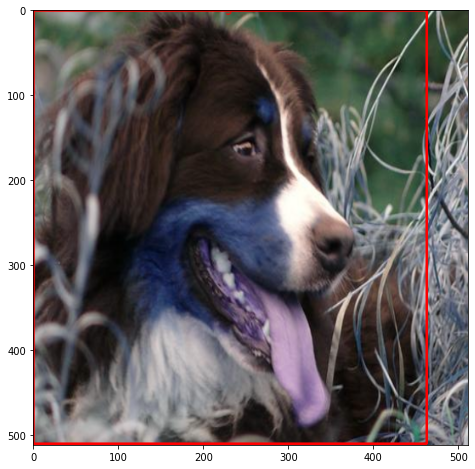

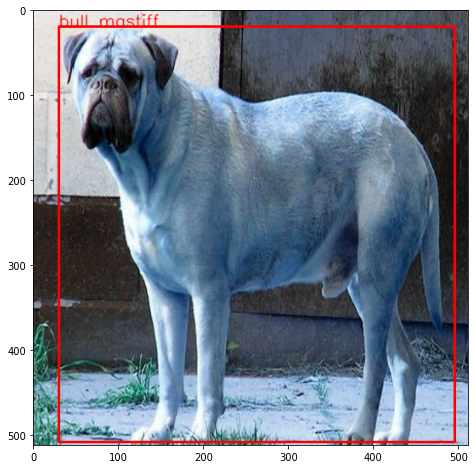

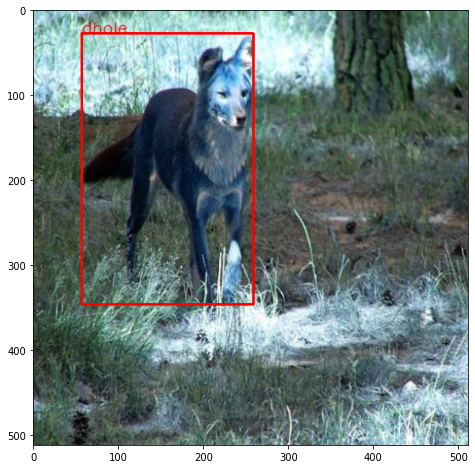

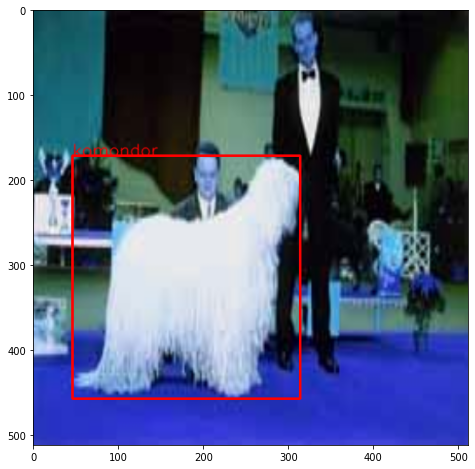

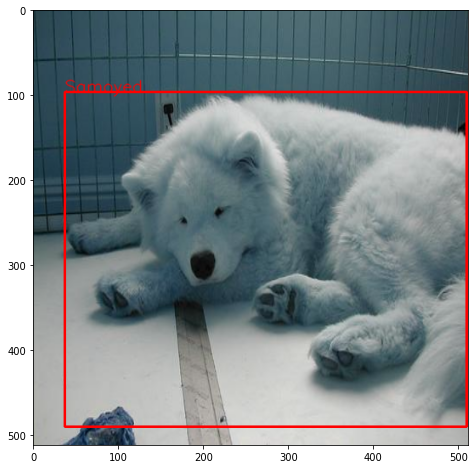

In [ ]:
for i in range(10):
  img_path = test_images[i]
  label = test_labels[i]
  image, labels = main(img_path, label)
  predictions = model(image[None, ...], training=False)
  feature_layers=[64, 32, 16, 8, 6, 4]
  feature_box=create_df_box(feature_layers)
  feature_box=convert_scale(feature_box,'abs')
  final_boxes, final_cls_idx, final_cls_scores = decode(labels[None, ...],feature_box)
  decoder_show_img(img_path , final_boxes,final_cls_idx,class_map)